# Mastering Scene Understanding:  Scene Graphs to the Rescue

## Text-based Retrieval of complex scene images
-----


## SEMScene: Semantic-Consistency Enhanced Multi-Level Scene Graph Matching for Image-Text Retrieval
Based on the [Official Implementation](https://github.com/MartinYuanNJU/SEMScene) for [SEMScene: Semantic-Consistency Enhanced Multi-Level Scene Graph Matching for Image-Text Retrieval](https://dl.acm.org/doi/abs/10.1145/3664816).

### Setting up the Environment and Data
---
#### Requirements
Requirements can be installed on a conda/micromamba environment using `semscene.yaml`:

```
micromamba create -f semscene.yaml
micromamba activate semscene
```

#### Data 
The model needs basic data including adjacency matrix based on the connections of predicates and triplets of sentence extracted through leveraging the [SceneGraphParser](https://github.com/vacancy/SceneGraphParser), which can be obtained here: [flickr30k](https://drive.google.com/drive/folders/1W02ub0UtV6wE41v59qa9pfxArKGIMtvv?usp=drive_link). Please download and place these files in the `data_flickr30k/data`folder

The visual features of objects and predicates are also needed, the authors followed [LGSGM](https://github.com/m2man/LGSGM) and used **EfficientNet-b5** to extract these features, they can be downloaded here: [flickr30k_visual](https://drive.google.com/drive/folders/1IvlmTZ9wUpOVIr9MzPgWZB5aYTaTD0jn). Please download and place them in the `data_flickr30k/` folder.

#### Pre-trained model
Pretrained models are were made available by the authors on a temporary basis [here](https://drive.google.com/drive/folders/1weVZduxLwtRn5Q6TBi3n6dBwN9AiUQao?usp=drive_link). Within this notebook we consider these files are at `pretrained/`


### Setting up the code
----
We start with the imports

In [1]:
import os
import joblib

from SEMScene.SEMScene import Trainer
from SEMScene.Data_Utils import *
from SEMScene.Retrieval_Utils import *

from PIL import Image
import matplotlib.pyplot as plt

/home/leo.ribeiro/micromamba/envs/semscene/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup the directory with the images from Flickr30K

In [2]:
dataset_dir = '/hadatasets/flickr30k/flickr30k_images/flickr30k_images'
metadata_dir = './data_flickr30k/data'
subset = 'test'

Create our model, the initializer will load the necessary metadata. Then we load our model checkpoint

In [3]:
trainer = Trainer()
trainer.load_trained_model(checkpoint='./pretrained/Node.pth.tar')

[SEMScene] Loading metadata...
[SEMScene] There are 10182 words, 150 total objects and 50 total predicates in Flickr30K
[SEMScene] Loading captions and scene graphs...
[SEMScene] Loading glove embeddings...
[SEMScene] Initilised with given init_weight
[SEMScene] Initilised with given init_weight
[SEMScene] Initilised with given init_weight
[SEMScene] Loaded pre-trained model at ./pretrained/Node.pth.tar


/home/leo.ribeiro/micromamba/envs/semscene/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Preprocessed set of images and captions 
---
To save on time we load images all cropped up by object and ground truth scene graphs for images and captions

In [4]:
images_data = joblib.load(f"{metadata_dir}/flickr30k_{subset}_lowered_images_data_adj.joblib")
caps_data = joblib.load(f"{metadata_dir}/flickr30k_{subset}_lowered_caps_data_adj.joblib")
list_image_id = np.array(list(images_data.keys()))

### Extracting features
---
To make retrieval work we have to extract features for the entire "database" (our images) so that we can later compare these with our search query

In [5]:
(img_obj_emb, img_pred_emb, img_numb_o_all, img_numb_p_all, 
 img_numb_p_all_xx, img_id_all, img_o_all, img_p_all,
 img_obj_all, img_mask_all) = trainer.encode_image_sgg(images_data, batch_size=16)

[SEMScene] Embedding objects and predicates of images ...


We then pick a caption from our ready-made set to use as a query. On a proper application one would write a novel caption, extract the caption's scene graph (the authors of this paper used [SceneGraphParser](https://github.com/vacancy/SceneGraphParser)) and then extract using the scene graph.

In [6]:
caption_idx = 0
c_dts = CaptionDataset(caption_sgg=caps_data, word2idx=trainer.word2idx_cap, numb_sample=None)
caps_data[c_dts[caption_idx]['id']]

{'sent': 'the man with pierced ears is wearing glasses and an orange hat.',
 'rels': [['man', 'with', 'ears'],
  ['man', 'wearing', 'glasses'],
  ['man', 'wearing', 'orange hat']],
 'adj': array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])}

We encode our selected caption

In [7]:
(cap_sent_emb, cap_rels_emb, cap_len_sent_all,
 cap_numb_rels_all, cap_id_all, eb_cap_o_all,
 eb_cap_numb_o_all, eb_cap_p_all, eb_cap_numb_p_all,
 cap_obj_all, cap_mask_all) = trainer.encode_single_caption_sgg(c_dts, caption_idx)

[SEMScene] Embedding captions data_flickr30k ...


### Using extracted features for retrieval
---
Now that we have all image features and one query/caption feature we can compare our query against all image features. The most similar ones should be semantically related to the query. Below we compute all the similarities

In [8]:
sims1 = shard_xattn_t2i(img_obj_emb, img_numb_o_all, cap_sent_emb, cap_len_sent_all, shard_size=128)
sims2 = shard_xattn_t2i(img_pred_emb, img_numb_p_all, cap_rels_emb, cap_numb_rels_all, shard_size=128)
sims = sims1 + 1.0 * sims2

if trainer.info_dict['model_name'].lower() == 'triplet':
    sims += sim_glo

With all similarities we sort and identify the most similar images

In [9]:
top_n = 5
top_idx = np.argsort(sims, axis=0)[::-1][0:top_n]
top_n_filenames = list_image_id[top_idx]

We load up the corresponding images to show here

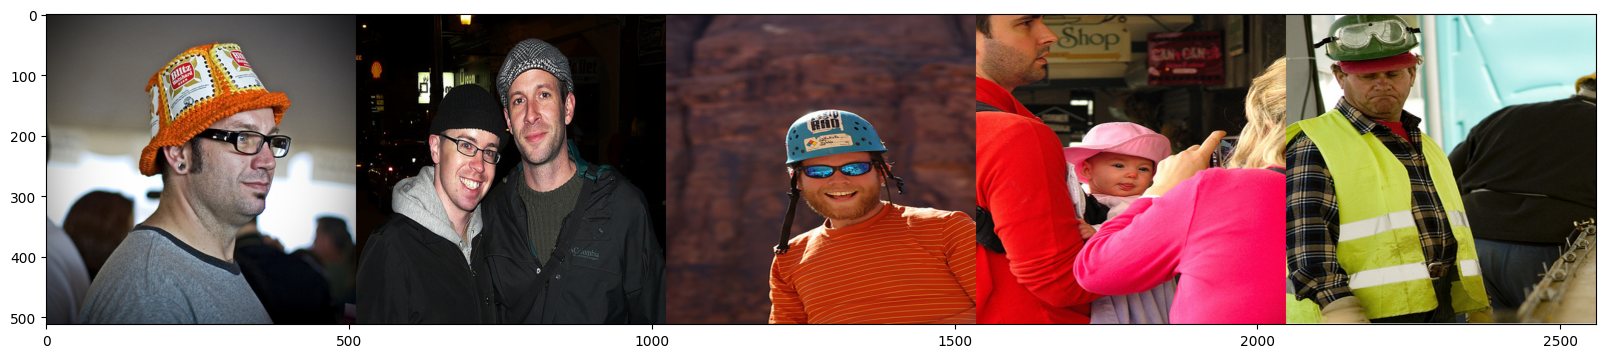

In [10]:
top_n_filepaths = [os.path.join(dataset_dir, file[0]) for file in top_n_filenames]
top_n_images = [Image.open(file).resize((512, 512)) for file in top_n_filepaths]
np.concatenate(top_n_images)

plt.figure(figsize=(20,8))
plt.imshow(np.concatenate(top_n_images, axis=1))